# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Variable Definations and Dataset Setup

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"archive/PlantVillage",
shuffle=True,
image_size = (IMAGE_SIZE, IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


# Playing with Dataset to Know More

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 2 0 0 2 1 0 0 0 0 1 2 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1]


# Visualisation

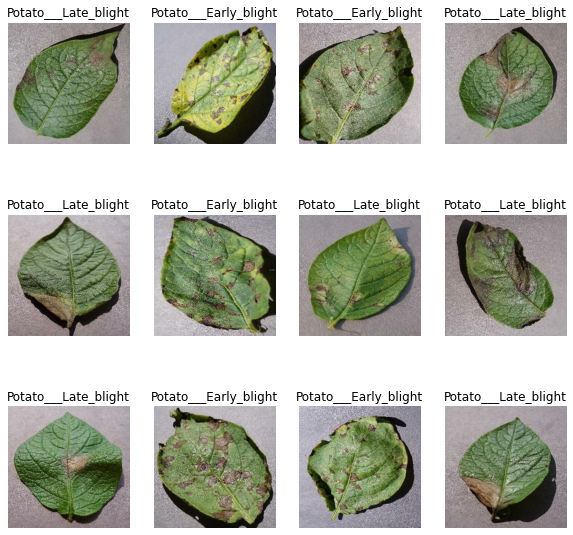

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [15]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds =dataset.skip(54)
len(test_ds)

14

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

# Dataset Partitioning Function

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size =10000):
    
    """ This is a function to Split Train Test Validate data from Dataset """
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


# Optimization

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)


# Resize and Rescaling

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Convolutional Nueral Network

In [39]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

# Summary

In [40]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

# Model Compile

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# History [Most Time consuming Cell nearly 1:30 hr]

In [57]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 182s 3s/step - loss: 0.0785 - accuracy: 0.9699 - val_loss: 0.1425 - val_accuracy: 0.9583
Epoch 2/50
54/54 [==============================] - 177s 3s/step - loss: 0.0746 - accuracy: 0.9711 - val_loss: 0.2039 - val_accuracy: 0.9010
Epoch 3/50
54/54 [==============================] - 131s 2s/step - loss: 0.0880 - accuracy: 0.9711 - val_loss: 0.3271 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 131s 2s/step - loss: 0.1036 - accuracy: 0.9618 - val_loss: 0.1489 - val_accuracy: 0.9427
Epoch 5/50
54/54 [==============================] - 131s 2s/step - loss: 0.0685 - accuracy: 0.9734 - val_loss: 0.0975 - val_accuracy: 0.9688
Epoch 6/50
54/54 [==============================] - 130s 2s/step - loss: 0.0732 - accuracy: 0.9745 - val_loss: 0.3382 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 132s 2s/step - loss: 0.1109 - accuracy: 0.9566 - val_loss: 0.1106 - val_accuracy: 0.9531
Epoch 8/50
54

In [58]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 984ms/step - loss: 0.1020 - accuracy: 0.9570


In [59]:
history

In [60]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
history.history['accuracy']

[0.49594905972480774,
 0.7065972089767456,
 0.8240740895271301,
 0.8871527910232544,
 0.8993055820465088,
 0.8923611044883728,
 0.9091435074806213,
 0.9189814925193787,
 0.9131944179534912,
 0.9375,
 0.9398148059844971,
 0.9508101940155029,
 0.9519675970077515,
 0.9467592835426331,
 0.9398148059844971,
 0.953125,
 0.9583333134651184,
 0.9473379850387573,
 0.9652777910232544,
 0.9751157164573669]

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Ploting

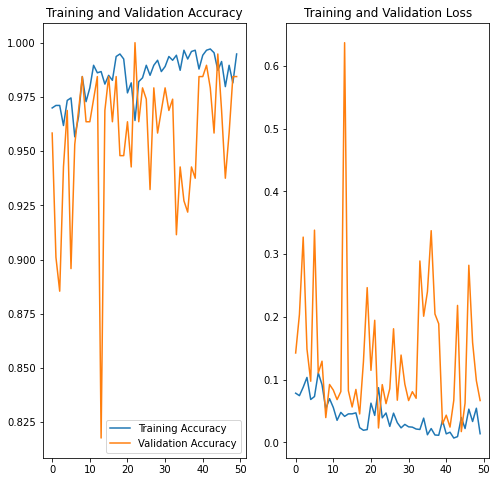

In [63]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')

plt.show()

# Prediction

First Image to predict
First image's actual label:  Potato___Late_blight
1/1 [==============================] - 1s 1s/step
1
Predicted label:  Potato___Late_blight


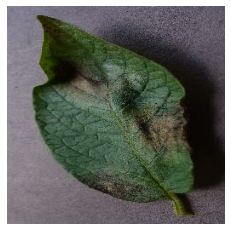

In [73]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label: ",class_names[first_label])
    
    batch_prediction =model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

# Prediction through Image

In [67]:
def predict_image(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 85ms/step


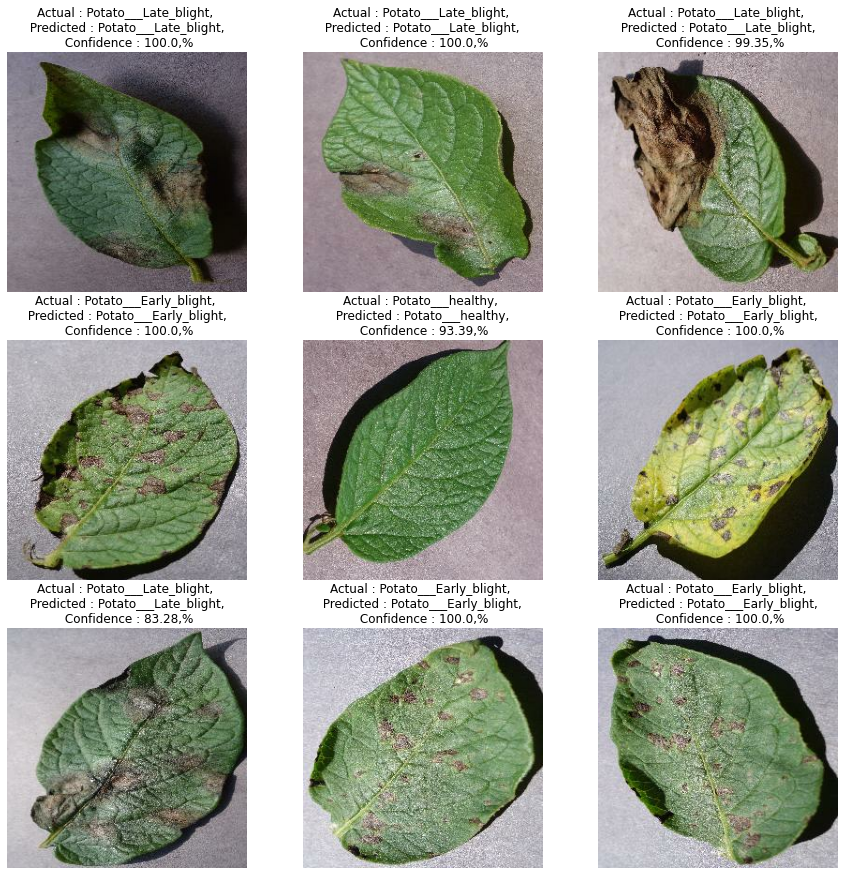

In [70]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_image(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence : {confidence},%")
        plt.axis("off")

In [71]:
model_version = 1
model.save(f"./Potato_Models/{model_version}")

INFO:tensorflow:Assets written to: ./Potato_Models/1\assets


INFO:tensorflow:Assets written to: ./Potato_Models/1\assets
